Dataset: 7 trials × 17 gestures
Channels: 16 forearm + 12 wrist = 28 total
Recording: 10240 samples, 5.0s @ 2048 Hz


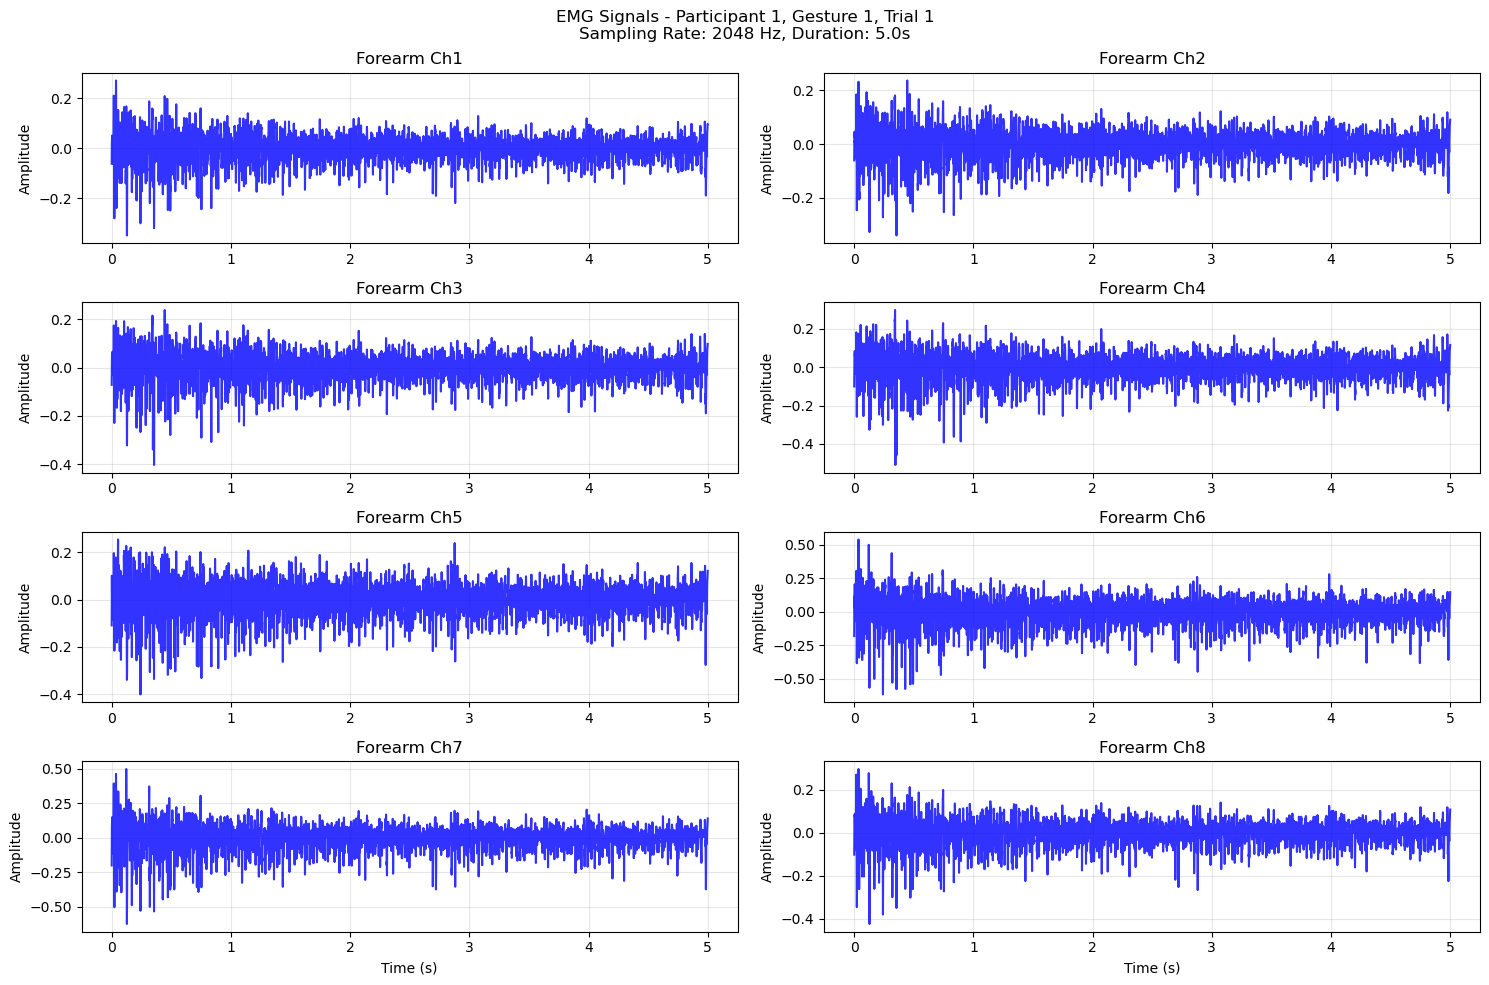

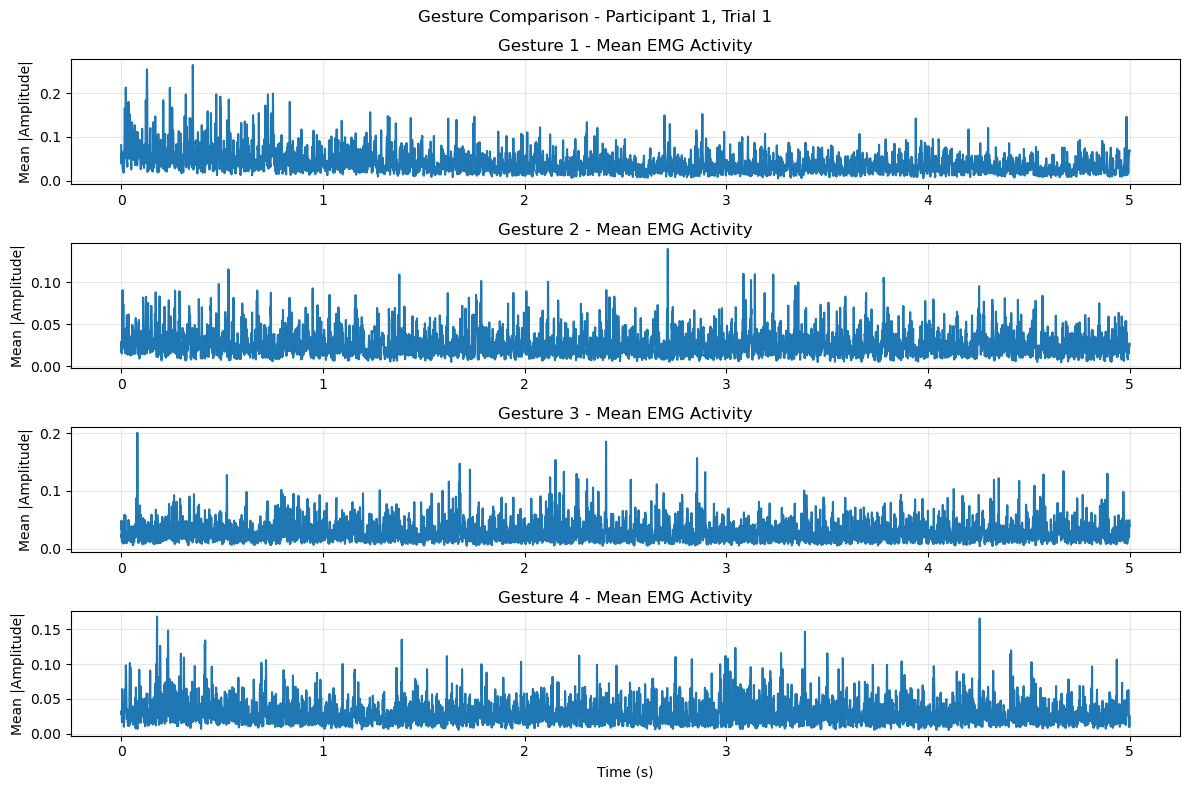

In [ ]:
from pathlib import Path
from natsort import natsorted
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

data_path = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted")
mat_files = natsorted(list(data_path.glob("*.mat")))

if mat_files:
    sample_file = mat_files[0]
    print(f"\nExamining file: {sample_file.name}")
    data = sio.loadmat(sample_file)


def calculate_sampling_rate(emg_data, expected_duration=5.0):
    """Calculate sampling rate from data shape."""
    n_samples = emg_data.shape[0]
    return n_samples / expected_duration

def plot_emg_overview(data, participant_id, gesture_idx=0, trial_idx=0, n_channels=8):
    """Create comprehensive EMG visualization with calculated parameters."""
    
    # Extract data
    forearm_emg = data['DATA_FOREARM'][trial_idx, gesture_idx]
    wrist_emg = data['DATA_WRIST'][trial_idx, gesture_idx]
    
    # Calculate actual sampling rate instead of hardcoding
    sampling_rate = calculate_sampling_rate(forearm_emg)
    
    # Combine data
    all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
    time_axis = np.arange(all_emg.shape[0]) / sampling_rate
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_channels//2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot channels with clear labeling
    for i in range(min(n_channels, all_emg.shape[1])):
        row, col = divmod(i, 2)
        
        # Determine channel source
        if i < forearm_emg.shape[1]:
            channel_label = f'Forearm Ch{i+1}'
            color = 'blue'
        else:
            channel_label = f'Wrist Ch{i-forearm_emg.shape[1]+1}'
            color = 'red'
            
        axes[i].plot(time_axis, all_emg[:, i], color=color, alpha=0.8)
        axes[i].set_title(channel_label)
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)
        
        if i >= n_channels - 2:  # Bottom row
            axes[i].set_xlabel('Time (s)')
    
    plt.suptitle(f'EMG Signals - Participant {participant_id}, Gesture {gesture_idx+1}, Trial {trial_idx+1}\n'
                f'Sampling Rate: {sampling_rate:.0f} Hz, Duration: {time_axis[-1]:.1f}s', y=0.98)
    plt.tight_layout()
    return fig, sampling_rate

def compare_gestures(data, participant_id, gestures=[0, 1, 2], trial_idx=0):
    """Compare the same trial across different gestures."""
    
    fig, axes = plt.subplots(len(gestures), 1, figsize=(12, 8))
    if len(gestures) == 1:
        axes = [axes]
    
    for i, gesture_idx in enumerate(gestures):
        forearm_emg = data['DATA_FOREARM'][trial_idx, gesture_idx]
        wrist_emg = data['DATA_WRIST'][trial_idx, gesture_idx]
        all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
        
        sampling_rate = calculate_sampling_rate(forearm_emg)
        time_axis = np.arange(all_emg.shape[0]) / sampling_rate
        
        # Plot mean activity across all channels
        mean_activity = np.abs(all_emg).mean(axis=1)
        axes[i].plot(time_axis, mean_activity)
        axes[i].set_title(f'Gesture {gesture_idx+1} - Mean EMG Activity')
        axes[i].set_ylabel('Mean |Amplitude|')
        axes[i].grid(True, alpha=0.3)
        
        if i == len(gestures) - 1:
            axes[i].set_xlabel('Time (s)')
    
    plt.suptitle(f'Gesture Comparison - Participant {participant_id}, Trial {trial_idx+1}')
    plt.tight_layout()
    return fig

def get_data_summary(data):
    """Get comprehensive data summary without hardcoding."""
    forearm_shape = data['DATA_FOREARM'].shape
    wrist_shape = data['DATA_WRIST'].shape
    
    # Get sample recording info
    sample_forearm = data['DATA_FOREARM'][0, 0]
    sample_wrist = data['DATA_WRIST'][0, 0]
    
    sampling_rate = calculate_sampling_rate(sample_forearm)
    duration = sample_forearm.shape[0] / sampling_rate
    
    summary = {
        'trials': forearm_shape[0],
        'gestures': forearm_shape[1], 
        'forearm_channels': sample_forearm.shape[1],
        'wrist_channels': sample_wrist.shape[1],
        'total_channels': sample_forearm.shape[1] + sample_wrist.shape[1],
        'samples_per_recording': sample_forearm.shape[0],
        'sampling_rate': sampling_rate,
        'duration': duration
    }
    
    return summary

# Usage example (replace with your loaded data)
summary = get_data_summary(data)
print(f"Dataset: {summary['trials']} trials × {summary['gestures']} gestures")
print(f"Channels: {summary['forearm_channels']} forearm + {summary['wrist_channels']} wrist = {summary['total_channels']} total")
print(f"Recording: {summary['samples_per_recording']} samples, {summary['duration']:.1f}s @ {summary['sampling_rate']:.0f} Hz")

fig1, sr = plot_emg_overview(data, participant_id=1, gesture_idx=0, trial_idx=0)
fig2 = compare_gestures(data, participant_id=1, gestures=[0, 1, 2, 3])
plt.show()

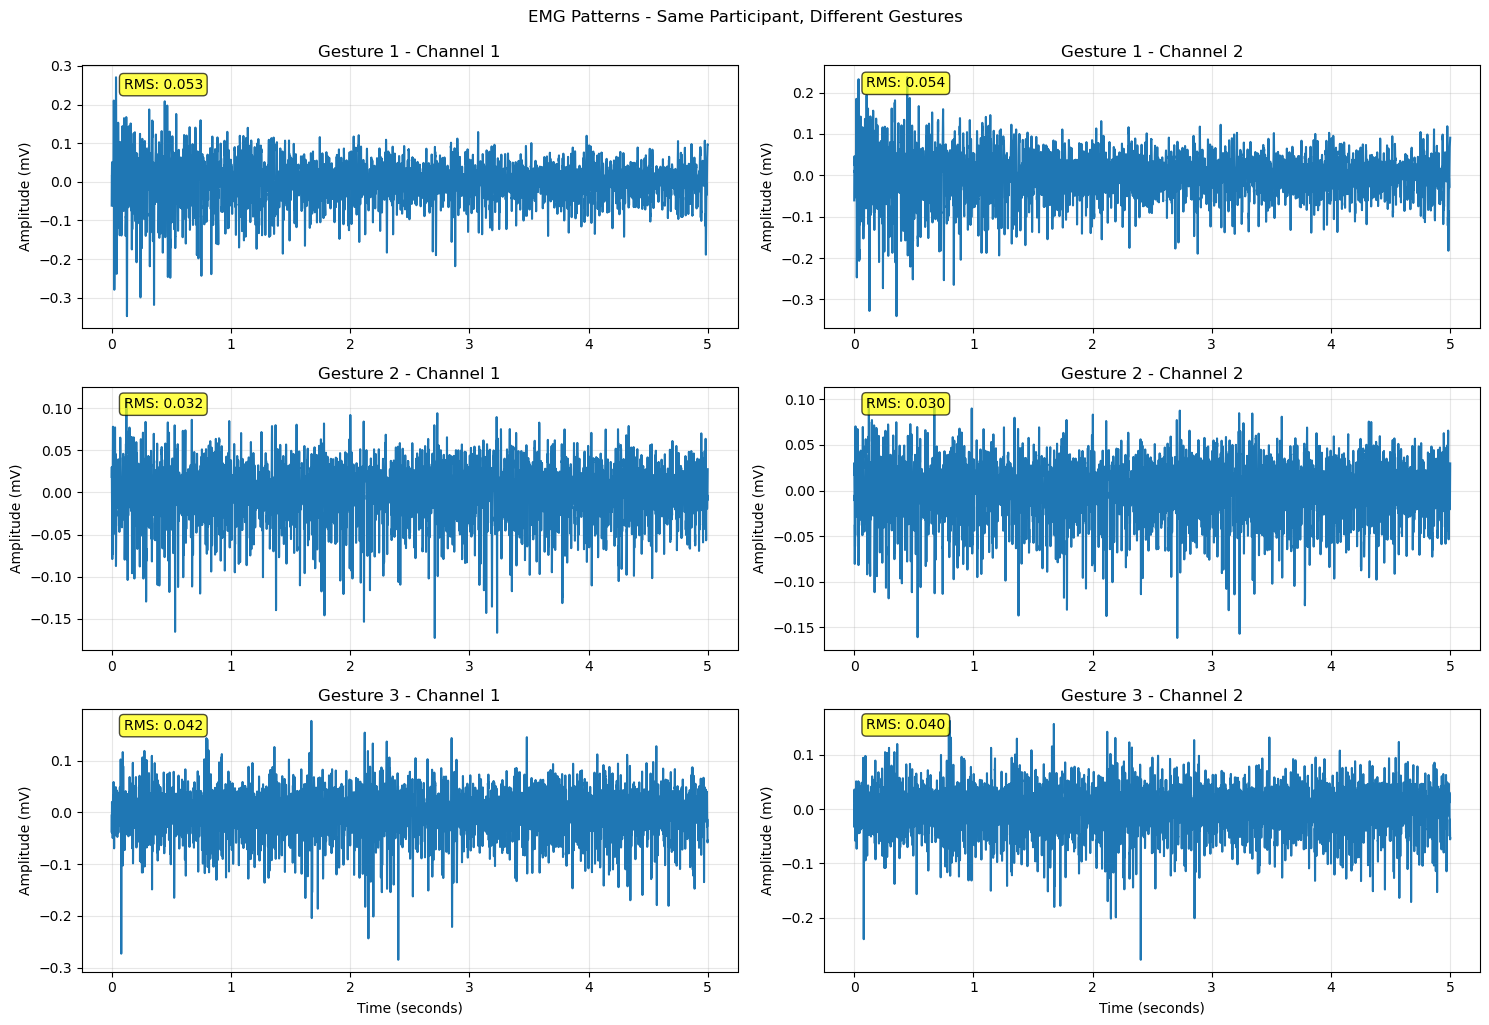

RMS Comparison (measure of muscle activity level):
--------------------------------------------------
Gesture 1: [np.float64(0.05325029107787748), np.float64(0.05352729487353327), np.float64(0.058533025217871175), np.float64(0.07024216811823615)]
Gesture 2: [np.float64(0.03159854974955929), np.float64(0.030322328771605445), np.float64(0.030092371840791506), np.float64(0.03134934522539506)]
Gesture 3: [np.float64(0.04181360581490045), np.float64(0.040269587698616736), np.float64(0.03877901179712235), np.float64(0.038774340177328344)]

What this tells us:
1. Different gestures have different EMG patterns
2. Some channels are more active for certain gestures
3. RMS values vary between gestures → good for classification
4. This is WHY machine learning can distinguish gestures!


In [ ]:
# Compare EMG patterns for different gestures
# This will show you WHY classification is possible

# Extract data for first 3 gestures, same trial
gesture_names = ['Gesture 1', 'Gesture 2', 'Gesture 3']  # We don't know exact names yet
trial_idx = 0  # First trial

plt.figure(figsize=(15, 10))

for i, gesture_idx in enumerate([0, 1, 2]):  # First 3 gestures
    # Get EMG data for this gesture
    forearm_emg = data['DATA_FOREARM'][trial_idx, gesture_idx]
    wrist_emg = data['DATA_WRIST'][trial_idx, gesture_idx]
    all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
    
    # Create time axis
    time_axis = np.arange(all_emg.shape[0]) / 2048
    
    # Plot first 2 channels for each gesture
    for ch in range(2):
        plt.subplot(3, 2, i*2 + ch + 1)
        plt.plot(time_axis, all_emg[:, ch])
        plt.title(f'{gesture_names[i]} - Channel {ch+1}')
        plt.ylabel('Amplitude (mV)')
        if i == 2:  # Bottom row
            plt.xlabel('Time (seconds)')
        plt.grid(True, alpha=0.3)
        
        # Add some basic statistics
        rms_value = np.sqrt(np.mean(all_emg[:, ch]**2))
        plt.text(0.1, plt.ylim()[1]*0.8, f'RMS: {rms_value:.3f}', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.suptitle('EMG Patterns - Same Participant, Different Gestures', y=1.02)
plt.show()

# Calculate and compare RMS (Root Mean Square) values
print("RMS Comparison (measure of muscle activity level):")
print("-" * 50)

for i, gesture_idx in enumerate([0, 1, 2]):
    forearm_emg = data['DATA_FOREARM'][trial_idx, gesture_idx]
    wrist_emg = data['DATA_WRIST'][trial_idx, gesture_idx]
    all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
    
    # Calculate RMS for first 4 channels
    rms_values = [np.sqrt(np.mean(all_emg[:, ch]**2)) for ch in range(4)]
    print(f"Gesture {gesture_idx+1}: {rms_values}")

print("\nWhat this tells us:")
print("1. Different gestures have different EMG patterns")
print("2. Some channels are more active for certain gestures") 
print("3. RMS values vary between gestures → good for classification")
print("4. This is WHY machine learning can distinguish gestures!")